# Human bone marrow of healthy human donors - Annotation

In this notebook, we annotate cyTOF data of bone marrow samples from 8 healthy donors. Data were provided by Oetjen et al (JCl Insight, 2018). 
We employ the following steps:
1. Read anndata formatted data
2. Annotate based on clustering
3. Compare to annotation provided by the authors (in publication).

In [1]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime
import pytometry as pm


sc.logging.print_versions()
sc.settings.verbosity = 3

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         8.4.0
anyio                       NA
asciitree                   NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.0.9
certifi                     2021.10.08
cffi                        1.15.0
charset_normalizer          2.0.7
cycler                      0.10.0
cython_runt

In [2]:
sc.settings.figdir = "./../figures/"

Add date.

In [3]:
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

Define a nice colour map for marker intensity.

In [4]:
colors2 = pl.cm.Reds(np.linspace(0, 1, 80))
colors3 = pl.cm.Greys_r(np.linspace(0.7, 0.8, 10))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list("my_colormap", colorsComb)

In [5]:
import os

In [6]:
data_path = "./../data/Oetjen_2018/"

## Read data

Read the anndata object from the previous notebook. Here, we stored the arcsinh-normalised and filtered events for all donors. 

In [7]:
adata_all = sc.read(data_path + "anndata/" + "cytof_data_norm.h5ad")

In [8]:
adata_all

AnnData object with n_obs × n_vars = 4829382 × 34
    obs: 'sample', 'Time', 'Event-length', 'Center', 'Offset', 'Width', 'Residual', 'batch', 'DNA1', 'DNA2', 'VIABILITY'
    var: 'channel', 'marker', 'signal_type', 'AB'
    uns: 'meta', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'compensated'
    obsp: 'connectivities', 'distances'

Check sample size, i.e. the number of events per donor.

In [9]:
adata_all.obs["sample"].value_counts()

B    940911
O    923137
H    827621
J    584961
T    503578
A    484678
C    370639
U    193857
Name: sample, dtype: int64

## Exploratory data analysis

In this section, we aim to get an overview on the data set. In particular, we check visually for batch effects (donor specific shifts in the data distribution). The PCA gives us an idea on the intrinsic dimension of the data.   

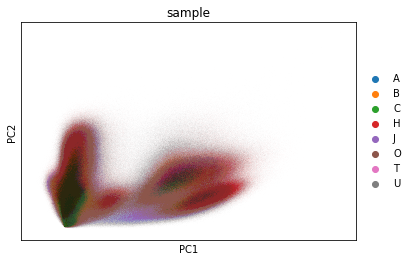

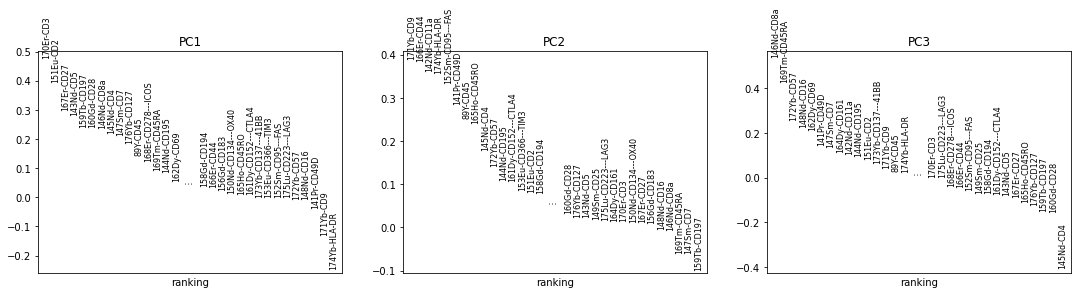

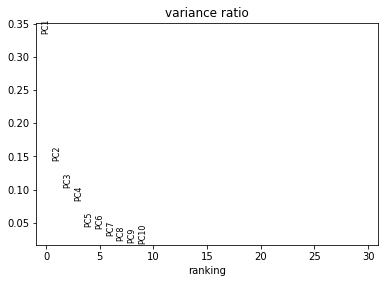

In [10]:
sc.pl.pca_overview(adata_all, color="sample")

Visualise the data as UMAP (pre-computed in the previous notebook). The visual distribution of cells from different donors allows to assume that we have very little shifts due to batch effects. 

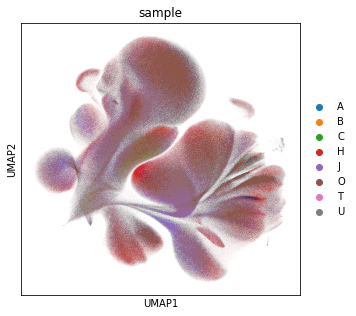

In [12]:
rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(adata_all, color="sample")

Next, we color the UMAP by all markers, where we use the custom color scheme of grey (no signal or only background) and reds to indicate the marker intensity. This map gives us an intuition for the cell distribution. 

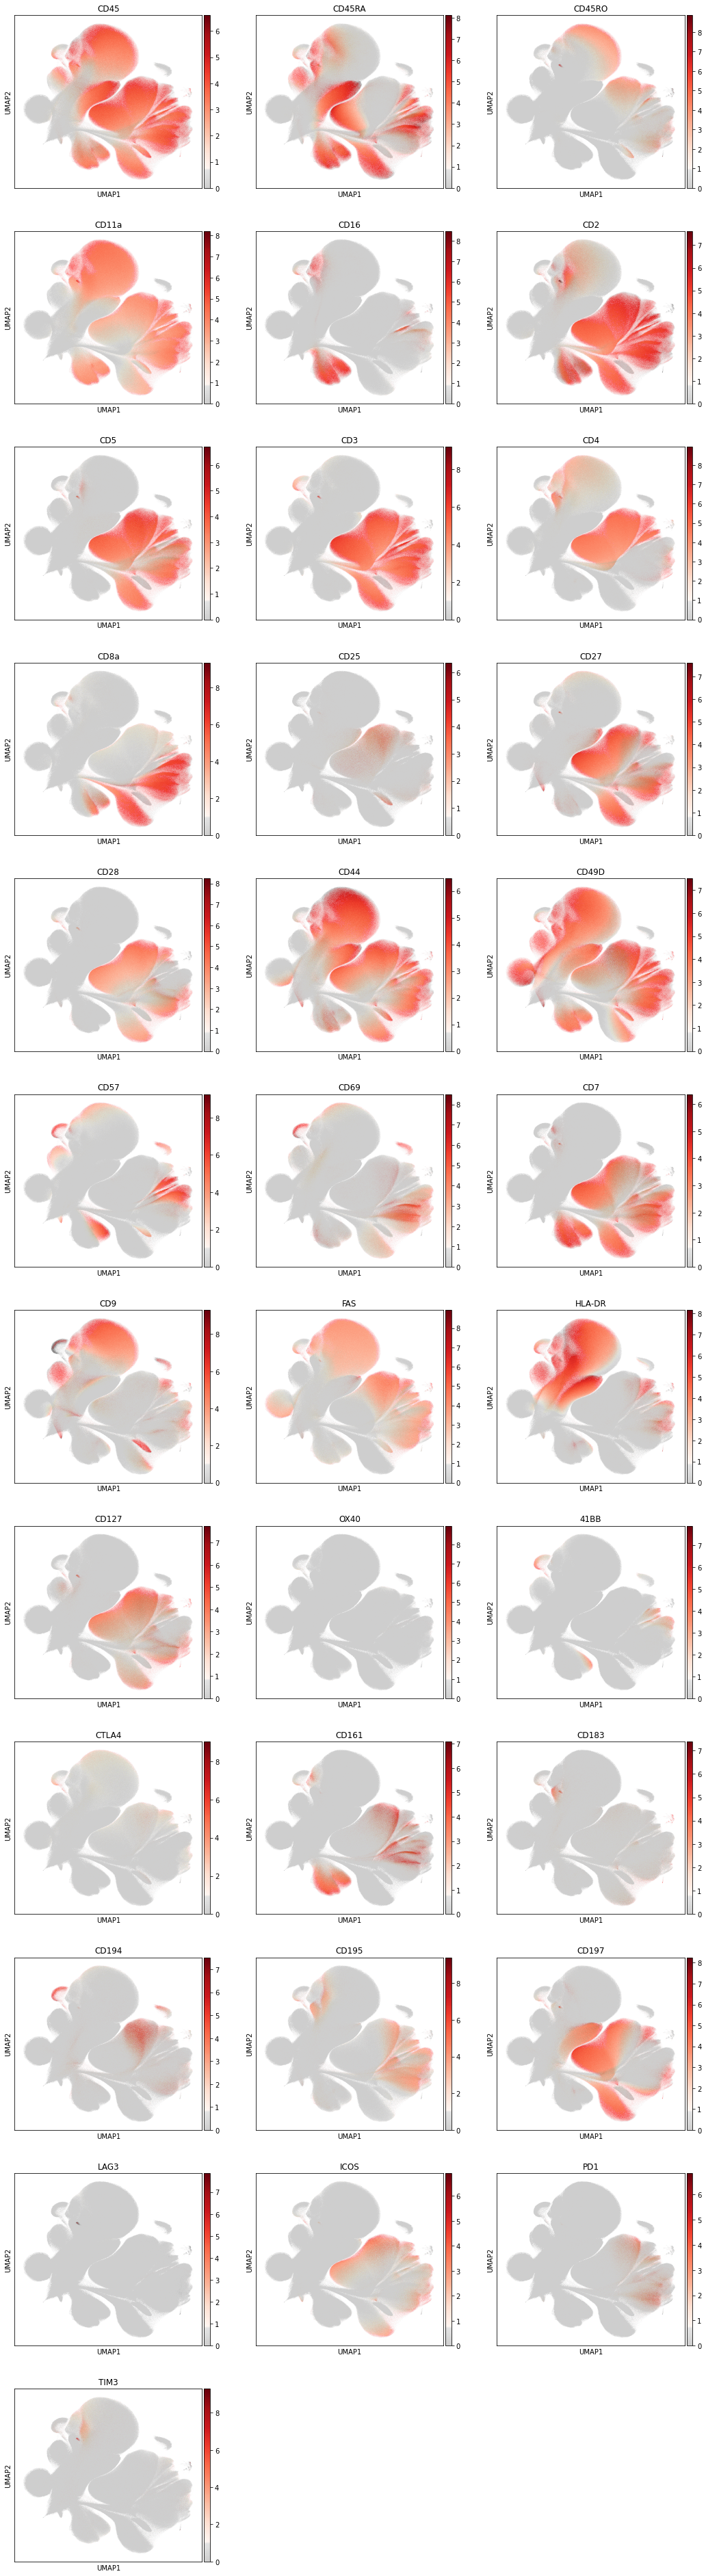

In [14]:
sc.pl.umap(
    adata_all,
    gene_symbols="AB",
    color=[
        "CD45",
        "CD45RA",
        "CD45RO",
        "CD11a",
        "CD16",
        "CD2",
        "CD5",
        "CD3",
        "CD4",
        "CD8a",
        "CD25",
        "CD27",
        "CD28",
        "CD44",
        "CD49D",
        "CD57",
        "CD69",
        "CD7",
        "CD9",
        "FAS",
        "HLA-DR",
        "CD127",
        "OX40",
        "41BB",
        "CTLA4",
        "CD161",
        "CD183",
        "CD194",
        "CD195",
        "CD197",
        "LAG3",
        "ICOS",
        "PD1",
        "TIM3",
    ],
    ncols=3,
    color_map=mymap,
)

The exploratory analysis also shows that we have a variety of CD45 negative cells in the dataset. These cells are likely no immune cells. Before we continue with the cell type annotation, we filter out the CD45 negative cells. 

## Annotation

For cell type annotation, we use several levels of granularity based on marker intensity. The measured panel contains mostly T cell markers. We therefore cannot annotate B cells or the myeloid lineage. In the lymphoid lineage, we can distinguish NK cells and T cells. The annotation focusses on T cell subtypes, following the annotation of the original publication. The different levels are:

* Level 1: Immune cells and non-immune cells (CD45 marker)
* Level 2: NK cells and T cells
* Level 3: T cell subtypes (CD4, CD8, double positive and negative)
* Level 4: CD4 and CD8 T cell subtypes based on marker CD197 intensity)
* Level 5: naive, central and effector memory T cell subtypes

### Level 1

We start with a rough annotation into CD45+ and negative cells.

In [15]:
adata_all.obs["cell_type_lvl0"] = adata_all.X[:, adata_all.var["AB"] == "CD45"] > 0.5

In [16]:
adata_all.obs["cell_type_lvl0"] = adata_all.obs["cell_type_lvl0"].map(
    {True: "CD45+", False: "CD45-"}
)

/opt/python/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type_lvl0' as categorical


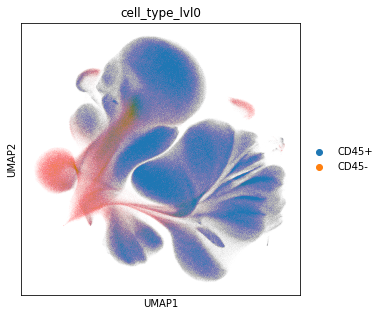

In [17]:
sc.pl.umap(adata_all, color="cell_type_lvl0")

Examine the number of CD45 positive and negative cells. 

In [18]:
adata_all.obs["cell_type_lvl0"].value_counts()

CD45+    4162929
CD45-     666453
Name: cell_type_lvl0, dtype: int64

### Level 2

We exclude the CD45- cells and continue with annotatin the CD45+ cells. 

In [20]:
adata_cd45 = adata_all[adata_all.obs["cell_type_lvl0"] == "CD45+"].copy()

Recompute PCA representation, UMAP embedding and clustering for subsequent cell type annotation.

In [ ]:
sc.pp.pca(adata_cd45)
sc.pp.neighbors(adata_cd45, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata_cd45)

computing PCA
    with n_comps=33
    finished (0:00:15)
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:17:42)
computing UMAP


In [ ]:
sc.tl.leiden(adata_cd45, resolution=1.0)

Save temporary result to file.

In [ ]:
adata_cd45.write(data_path + "anndata/" + "cytof_data_tmp.h5ad")

Read in the temporary data file.

In [7]:
adata_cd45 = sc.read(data_path + "anndata/" + "cytof_data_tmp.h5ad")

#### Visualize data

Similar to the exploratory data analysis shown above, we visualise the data using UMAP. In this step, we visualise the Leiden clustering of the data. Leiden clustering is a community detection based approach that tends to overcluster the data, but captures clusters of very different sizes. In this way, we can discover very rare cells types, even though abundant cell types are split into several subclusters. 

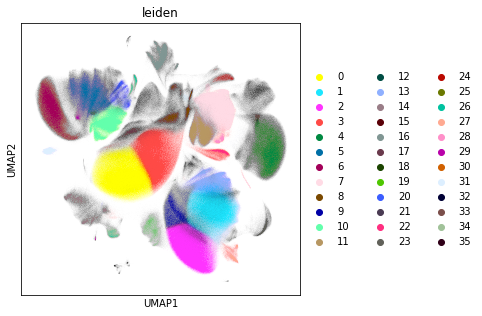

In [9]:
rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(adata_cd45, color="leiden")

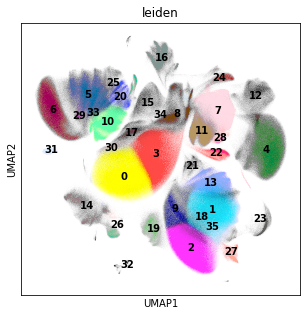

In [79]:
rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(adata_cd45, color="leiden", legend_loc="on data")

Let us inspect the marker intensity on a UMAP. 

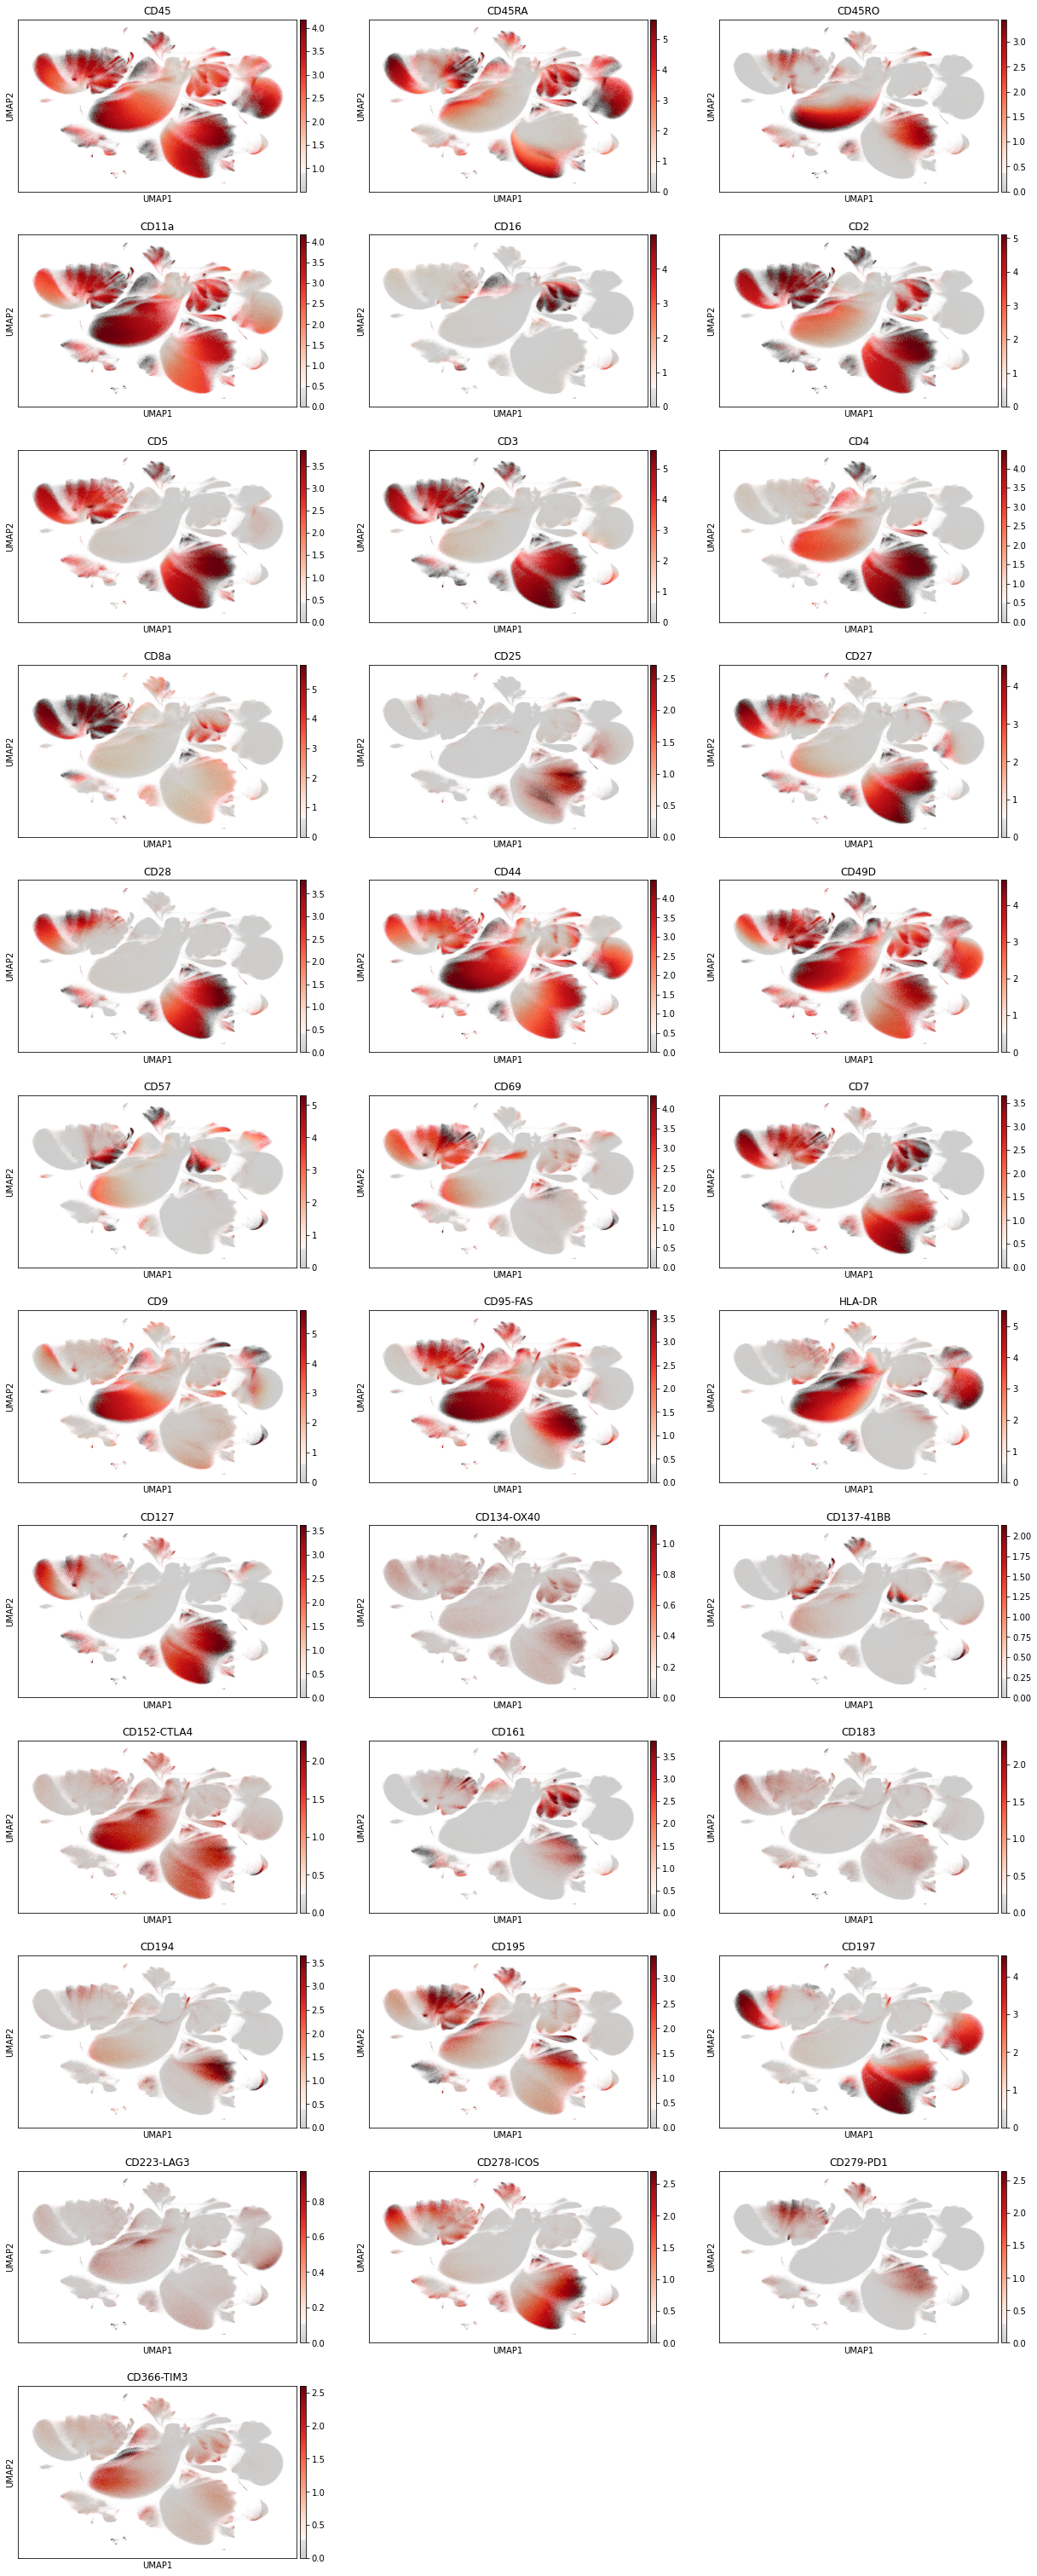

In [22]:
sc.pl.umap(
    adata_cd45,
    gene_symbols="AB",
    color=[
        "CD45",
        "CD45RA",
        "CD45RO",
        "CD11a",
        "CD16",
        "CD2",
        "CD5",
        "CD3",
        "CD4",
        "CD8a",
        "CD25",
        "CD27",
        "CD28",
        "CD44",
        "CD49D",
        "CD57",
        "CD69",
        "CD7",
        "CD9",
        "CD95-FAS",
        "HLA-DR",
        "CD127",
        "CD134-OX40",
        "CD137-41BB",
        "CD152-CTLA4",
        "CD161",
        "CD183",
        "CD194",
        "CD195",
        "CD197",
        "CD223-LAG3",
        "CD278-ICOS",
        "CD279-PD1",
        "CD366-TIM3",
    ],
    ncols=3,
    color_map=mymap,
    vmax="p99",
)

Let us inspect the mean marker intensity as a matrixplot. Clusters are organised based on hierarchical clustering. 

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


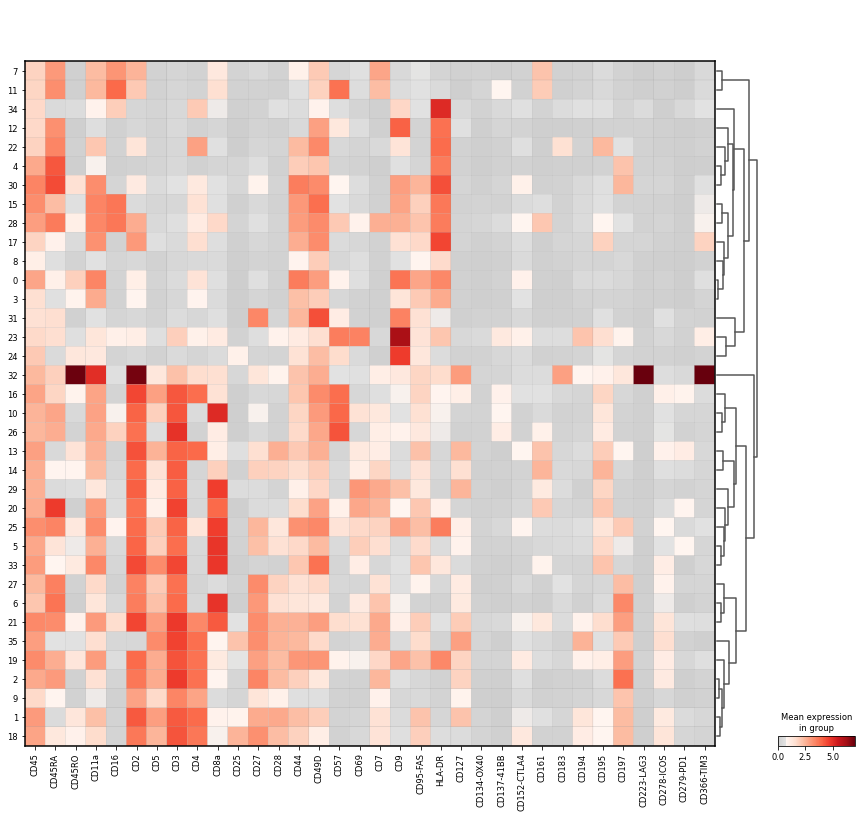

In [82]:
sc.pl.matrixplot(
    adata_cd45,
    groupby="leiden",
    gene_symbols="AB",
    var_names=[
        "CD45",
        "CD45RA",
        "CD45RO",
        "CD11a",
        "CD16",
        "CD2",
        "CD5",
        "CD3",
        "CD4",
        "CD8a",
        "CD25",
        "CD27",
        "CD28",
        "CD44",
        "CD49D",
        "CD57",
        "CD69",
        "CD7",
        "CD9",
        "CD95-FAS",
        "HLA-DR",
        "CD127",
        "CD134-OX40",
        "CD137-41BB",
        "CD152-CTLA4",
        "CD161",
        "CD183",
        "CD194",
        "CD195",
        "CD197",
        "CD223-LAG3",
        "CD278-ICOS",
        "CD279-PD1",
        "CD366-TIM3",
    ],
    dendrogram=True,
    vmin=0,
    cmap=mymap,
)

Markers for NK cells: 
* CD16+ 
* HLA-DR-
* CD3-
* CD44- 
* CD45RA+

Markers for neutrophils (in distinction to NK cells):
* CD16+
* CD44+
* CD3-

Markers for T cells:
* CD3+ (general marker for T cells)
* CD4+
* CD8a+ 

Annotate T cells and NK cells in a second round.

In [11]:
cluster2cell = {
    "0": "not annotated",
    "1": "T cell",  #
    "2": "T cell",  #
    "3": "not annotated",
    "4": "not annotated",
    "5": "T cell",  #
    "6": "T cell",  #
    "7": "NK cell",  #
    "8": "not annotated",
    "9": "T cell",  #
    "10": "T cell",  #
    "11": "NK cell",  #
    "12": "not annotated",
    "13": "T cell",  #
    "14": "T cell",  #
    "15": "not annotated",
    "16": "T cell",  #
    "17": "not annotated",
    "18": "T cell",  #
    "19": "T cell",  #
    "20": "T cell",  #
    "21": "T cell",  # Double positive CD4/CD8
    "22": "not annotated",
    "23": "not annotated",
    "24": "not annotated",
    "25": "T cell",  #
    "26": "T cell",  #
    "27": "T cell",  #
    "28": "NK cell",  # HLA-DR positive NK cell?
    "29": "T cell",  #
    "30": "not annotated",
    "31": "not annotated",
    "32": "not annotated",
    "33": "T cell",  #
    "34": "not annotated",
    "35": "T cell",  #
}
adata_cd45.obs["cell_type_lvl2"] = adata_cd45.obs["leiden"].map(cluster2cell).copy()

/opt/python/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type_lvl2' as categorical


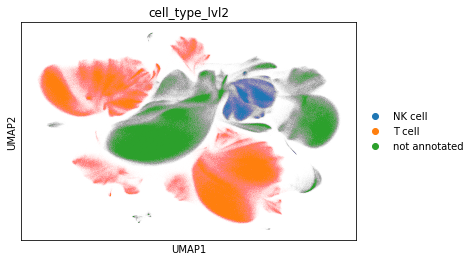

In [12]:
sc.pl.umap(adata_cd45, color="cell_type_lvl2")

In [13]:
df = pd.crosstab(
    adata_cd45.obs["sample"], adata_cd45.obs["cell_type_lvl2"], normalize=0
)

In [14]:
df

cell_type_lvl2   NK cell    T cell  not annotated
sample                                           
A               0.048344  0.624290       0.327366
B               0.092156  0.472933       0.434912
C               0.031945  0.403321       0.564733
H               0.084707  0.571623       0.343670
J               0.028097  0.510479       0.461425
O               0.069115  0.448752       0.482133
T               0.083106  0.431413       0.485481
U               0.037466  0.533421       0.429112

(0.0, 1.0)

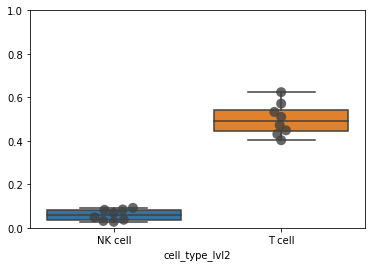

In [15]:
ax = sb.boxplot(data=df[["NK cell", "T cell"]], orient="v")
ax = sb.swarmplot(
    data=df[["NK cell", "T cell"]], orient="v", color=".25", size=10, alpha=0.8
)
ax.set_ylim([0, 1])

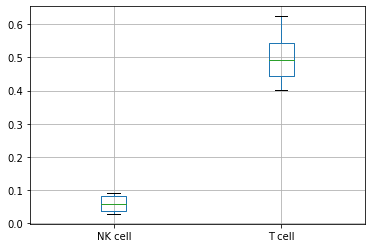

In [16]:
boxplot = df.boxplot(column=["NK cell", "T cell"])

### Level 3

Annotate T cell subtypes in a third round. Notes on markers:

* Double positive T cells: express both CD4 and CD8a
* Double negative T cells: express only CD3, but not CD4 or CD8a
* Distinguish CD4+ T cells and CD8+ T cells
* CCR7 is also known as CD197

In [17]:
cluster2cell = {
    "0": "not annotated",
    "1": "CD4+ T cell",  #
    "2": "CD4+ T cell",  #
    "3": "not annotated",
    "4": "not annotated",
    "5": "CD8+ T cell",  #
    "6": "CD8+ T cell",  #
    "7": "NK cell",  #
    "8": "not annotated",
    "9": "CD4+ T cell",  #
    "10": "CD8+ T cell",  #
    "11": "NK cell",  #
    "12": "not annotated",
    "13": "CD4+ T cell",  #
    "14": "CD8+ T cell",  #
    "15": "not annotated",
    "16": "CD4+ T cell",  #
    "17": "not annotated",
    "18": "CD4+ T cell",  #
    "19": "CD4+ T cell",  #
    "20": "CD8+ T cell",  #
    "21": "Double positive T cell",  # Double positive CD4/CD8
    "22": "not annotated",
    "23": "not annotated",
    "24": "not annotated",
    "25": "CD8+ T cell",  #
    "26": "Double negative T cell",  # very little CD8a
    "27": "Double negative T cell",  # has only CD3 marker
    "28": "NK cell",  # HLA-DR positive NK cell?
    "29": "CD8+ T cell",  #
    "30": "not annotated",
    "31": "not annotated",
    "32": "not annotated",  # special activated T cell or simply autofluorescence?
    "33": "CD8+ T cell",  #
    "34": "not annotated",
    "35": "CD4+ T cell",  #
}
adata_cd45.obs["cell_type_lvl3"] = adata_cd45.obs["leiden"].map(cluster2cell).copy()

/opt/python/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type_lvl3' as categorical


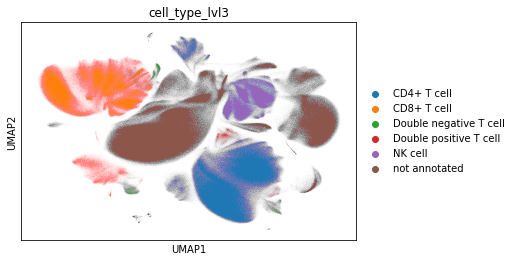

In [18]:
sc.pl.umap(adata_cd45, color="cell_type_lvl3")

Check proportions. Restrict to CD4 and CD8 T cells.

In [49]:
obs_tmp = adata_cd45.obs.loc[
    adata_cd45.obs["cell_type_lvl3"].isin(["CD4+ T cell", "CD8+ T cell"])
]

In [50]:
df = pd.crosstab(obs_tmp["sample"], obs_tmp["cell_type_lvl4"], normalize=0)

In [51]:
df

cell_type_lvl4  CCR7+ CD4+ T cell  CCR7+ CD8+ T cell  CCR7- CD4+ T cell  \
sample                                                                    
A                        0.345225           0.052842           0.237266   
B                        0.592302           0.140645           0.024481   
C                        0.546661           0.055512           0.146351   
H                        0.502886           0.136178           0.062442   
J                        0.614723           0.263139           0.015905   
O                        0.374888           0.153879           0.097987   
T                        0.407082           0.245514           0.045433   
U                        0.657344           0.156213           0.045153   

cell_type_lvl4  CCR7- CD8+ T cell  
sample                             
A                        0.364666  
B                        0.242573  
C                        0.251477  
H                        0.298493  
J                        0.106233  
O                        0.373247  
T                        0.301972  
U                        0.141291

(0.0, 1.0)

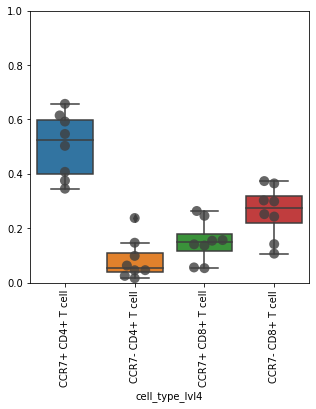

In [61]:
ax = sb.boxplot(
    data=df[
        [
            "CCR7+ CD4+ T cell",
            "CCR7- CD4+ T cell",
            "CCR7+ CD8+ T cell",
            "CCR7- CD8+ T cell",
        ]
    ],
    orient="v",
)
ax = sb.swarmplot(
    data=df[
        [
            "CCR7+ CD4+ T cell",
            "CCR7- CD4+ T cell",
            "CCR7+ CD8+ T cell",
            "CCR7- CD8+ T cell",
        ]
    ],
    orient="v",
    color=".25",
    size=10,
    alpha=0.8,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim([0, 1])

### Level 4

Annotate T cell subtypes in a fourth round. Notes on markers:

* Distinguish CCR7+/- cells in CD4+ T cells and CD8+ T cells
* CCR7 is also known as CD197

In [23]:
cluster2cell = {
    "0": "not annotated",
    "1": "CCR7+ CD4+ T cell",  #
    "2": "CCR7+ CD4+ T cell",  #
    "3": "not annotated",
    "4": "not annotated",
    "5": "CCR7- CD8+ T cell",  #
    "6": "CCR7+ CD8+ T cell",  #
    "7": "NK cell",  #
    "8": "not annotated",
    "9": "CCR7+ CD4+ T cell",  #
    "10": "CCR7- CD8+ T cell",  #
    "11": "NK cell",  #
    "12": "not annotated",
    "13": "CCR7- CD4+ T cell",  #
    "14": "CCR7- CD8+ T cell",  #
    "15": "not annotated",
    "16": "CCR7- CD4+ T cell",  #
    "17": "not annotated",
    "18": "CCR7+ CD4+ T cell",  #
    "19": "CCR7+ CD4+ T cell",  #
    "20": "CCR7- CD8+ T cell",  #
    "21": "Double positive T cell",  # Double positive CD4/CD8
    "22": "not annotated",
    "23": "not annotated",
    "24": "not annotated",
    "25": "CCR7+ CD8+ T cell",  #
    "26": "Double negative T cell",  # very little CD8a
    "27": "Double negative T cell",  # has only CD3 marker
    "28": "NK cell",  # HLA-DR positive NK cell?
    "29": "CCR7- CD8+ T cell",  #
    "30": "not annotated",
    "31": "not annotated",
    "32": "not annotated",  # special activated T cell or simply autofluorescence?
    "33": "CCR7- CD8+ T cell",  #
    "34": "not annotated",
    "35": "CCR7+ CD4+ T cell",  #
}
adata_cd45.obs["cell_type_lvl4"] = adata_cd45.obs["leiden"].map(cluster2cell).copy()

/opt/python/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type_lvl4' as categorical


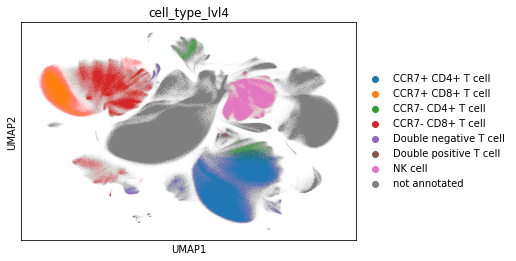

In [24]:
sc.pl.umap(adata_cd45, color="cell_type_lvl4")

Check proportions. Restrict to CD4 and CD8 T cells.

In [49]:
obs_tmp = adata_cd45.obs.loc[
    adata_cd45.obs["cell_type_lvl3"].isin(["CD4+ T cell", "CD8+ T cell"])
]

In [50]:
df = pd.crosstab(obs_tmp["sample"], obs_tmp["cell_type_lvl4"], normalize=0)

In [51]:
df

cell_type_lvl4  CCR7+ CD4+ T cell  CCR7+ CD8+ T cell  CCR7- CD4+ T cell  \
sample                                                                    
A                        0.345225           0.052842           0.237266   
B                        0.592302           0.140645           0.024481   
C                        0.546661           0.055512           0.146351   
H                        0.502886           0.136178           0.062442   
J                        0.614723           0.263139           0.015905   
O                        0.374888           0.153879           0.097987   
T                        0.407082           0.245514           0.045433   
U                        0.657344           0.156213           0.045153   

cell_type_lvl4  CCR7- CD8+ T cell  
sample                             
A                        0.364666  
B                        0.242573  
C                        0.251477  
H                        0.298493  
J                        0.106233  
O                        0.373247  
T                        0.301972  
U                        0.141291

(0.0, 1.0)

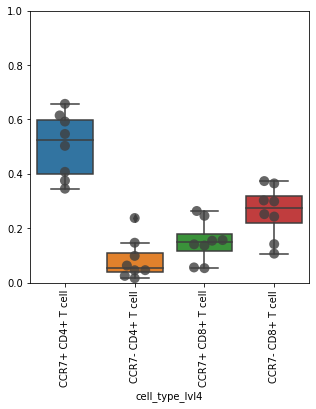

In [61]:
ax = sb.boxplot(
    data=df[
        [
            "CCR7+ CD4+ T cell",
            "CCR7- CD4+ T cell",
            "CCR7+ CD8+ T cell",
            "CCR7- CD8+ T cell",
        ]
    ],
    orient="v",
)
ax = sb.swarmplot(
    data=df[
        [
            "CCR7+ CD4+ T cell",
            "CCR7- CD4+ T cell",
            "CCR7+ CD8+ T cell",
            "CCR7- CD8+ T cell",
        ]
    ],
    orient="v",
    color=".25",
    size=10,
    alpha=0.8,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim([0, 1])

### Level 5

Annotate T cell subtypes in a fifth round. Notes on markers:

* Distinguish Naive, Central Memory (CM), Effector Memory (EM) and terminally differentiated effector memory T cells (TEMRA) in CD4+ T cells and CD8+ T cells with CD45RA:
    * CCR7+ CD45RA+ is a Naive T cell
    * CCR7+ CD45RA- is a CM T cell
    * CCR7- CD45RA+ is a TEMRA
    * CCR7- CD45RA+ in CD8+ T cells is an effector T cell (TE)
    * CCR7- CD45RA- is an EM T cell
    * CCR7- CD45RA- CD69+ is a Tissue-resident T cell (TRM)

* CCR7 is also known as CD197

In [81]:
cluster2cell = {
    "0": "not annotated",
    "1": "CD4+ CM T cell",  #
    "2": "Naive CD4+ T cell",  #
    "3": "not annotated",
    "4": "not annotated",
    "5": "CD8+ EM T cell",  #
    "6": "Naive CD8+ T cell",  #
    "7": "NK cell",  #
    "8": "not annotated",
    "9": "CD4+ CM T cell",  #
    "10": "CD8+ TE T cell",  #
    "11": "NK cell",  #
    "12": "not annotated",
    "13": "CD4+ EM T cell",  # mixed with TRM CCR7- CD45RA- CD69+
    "14": "CD8+ EM T cell",  # somewhat different to cluster 5
    "15": "not annotated",
    "16": "CD4+ TEMRA",  #
    "17": "not annotated",
    "18": "CD4+ CM T cell",  #
    "19": "Naive CD4+ T cell",  #
    "20": "CD8+ TE T cell",  #
    "21": "Double positive T cell",  # Double positive CD4/CD8
    "22": "not annotated",
    "23": "not annotated",
    "24": "not annotated",
    "25": "Naive CD8+ T cell",  #
    "26": "Double negative T cell",  # very little CD8a
    "27": "Double negative T cell",  # has only CD3 marker
    "28": "NK cell",  # HLA-DR positive NK cell?
    "29": "CD8+ TRM T cell",  # CCR7- CD45RA- CD69+
    "30": "not annotated",
    "31": "not annotated",
    "32": "not annotated",  # special activated T cell or simply autofluorescence?
    "33": "CD8+ EM T cell",  #
    "34": "not annotated",
    "35": "CD4+ CM T cell",  #
}
adata_cd45.obs["cell_type_lvl5"] = pd.Categorical(
    adata_cd45.obs["leiden"].map(cluster2cell).copy()
)

#### Subcluster

In addition to the initial clustering, we observe that cluster 13 is a mixture of CD4+ TRM cells and CD4+ EM T cells. Let us subcluster cluster 13 to resolve CD4+ TRMs.

In [27]:
sc.tl.leiden(adata_cd45, key_added="leiden_R", restrict_to=["leiden", ["13"]])

running Leiden clustering
    finished: found 52 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:46)


Cluster 5 is a mixture of naive CD8+ cells and CD8+ CM T cells. Subcluster cluster 5 to resolve CD8+ CMs.

In [66]:
sc.tl.leiden(adata_cd45, key_added="leiden_R", restrict_to=["leiden_R", ["5"]])

running Leiden clustering
    finished: found 67 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:07:12)


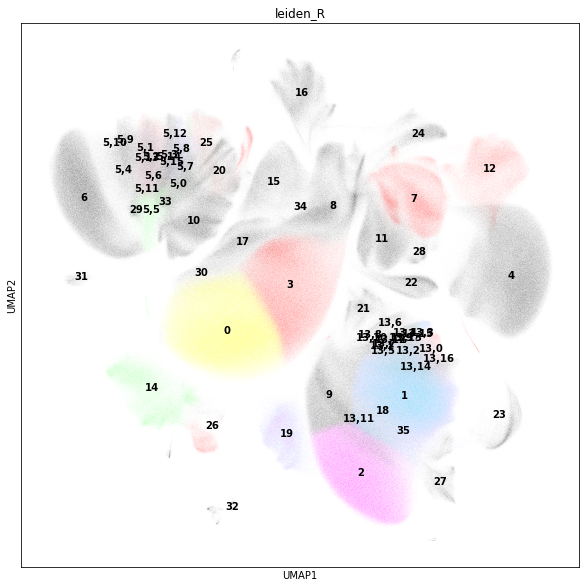

In [73]:
rcParams["figure.figsize"] = (10, 10)
sc.pl.umap(adata_cd45, color="leiden_R", legend_loc="on data")

Let us visualise the mean marker intensity as matrixplot to examine the intensity levels in the subclustered data. Also, we want to see where the subclusters are grouped. 

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden_R']`


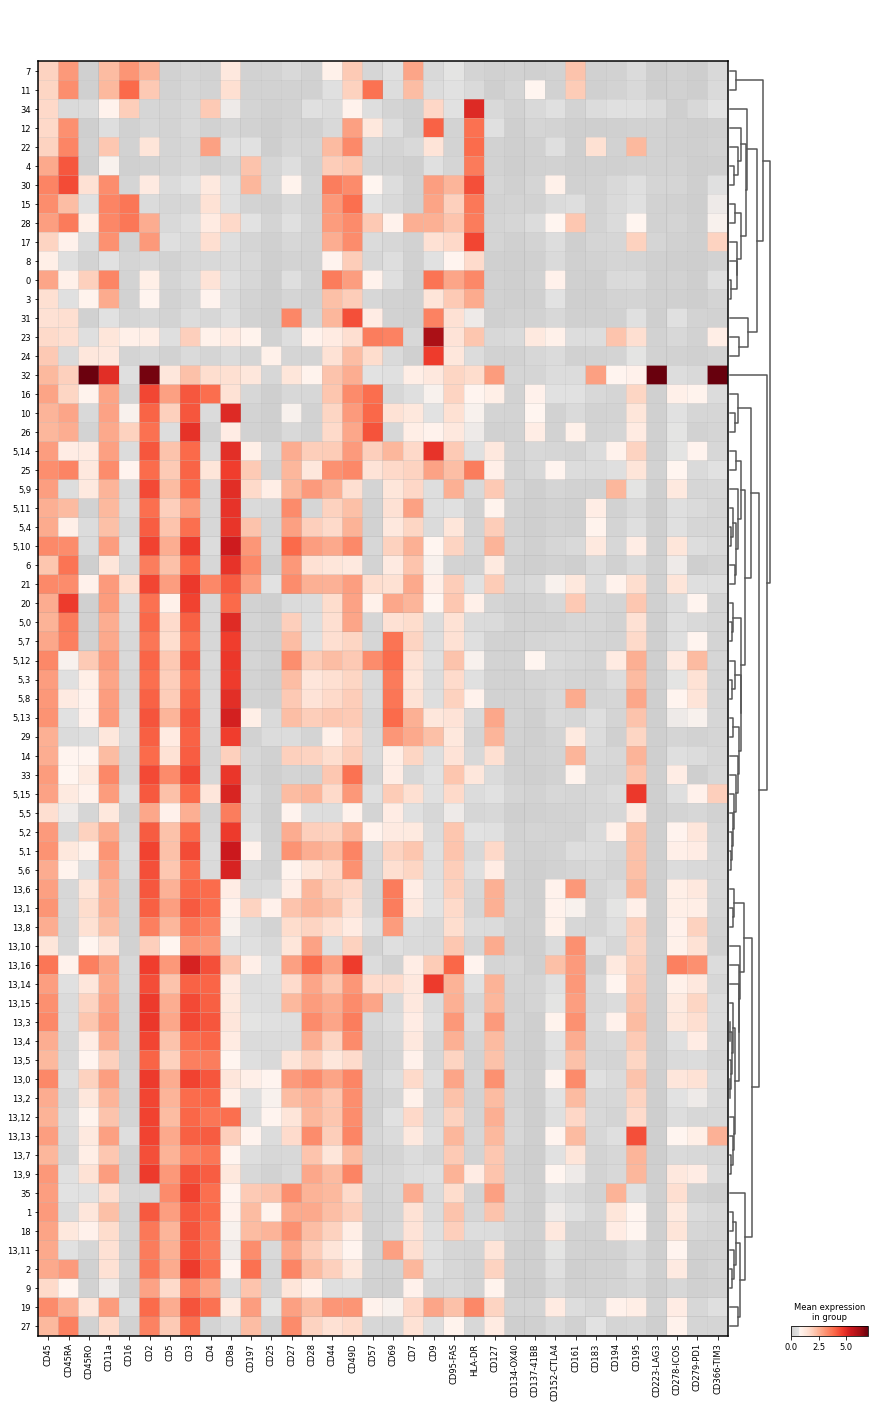

In [70]:
sc.pl.matrixplot(
    adata_cd45,
    groupby="leiden_R",
    gene_symbols="AB",
    var_names=[
        "CD45",
        "CD45RA",
        "CD45RO",
        "CD11a",
        "CD16",
        "CD2",
        "CD5",
        "CD3",
        "CD4",
        "CD8a",
        "CD197",
        "CD25",
        "CD27",
        "CD28",
        "CD44",
        "CD49D",
        "CD57",
        "CD69",
        "CD7",
        "CD9",
        "CD95-FAS",
        "HLA-DR",
        "CD127",
        "CD134-OX40",
        "CD137-41BB",
        "CD152-CTLA4",
        "CD161",
        "CD183",
        "CD194",
        "CD195",
        "CD223-LAG3",
        "CD278-ICOS",
        "CD279-PD1",
        "CD366-TIM3",
    ],
    dendrogram=True,
    vmin=0,
    cmap=mymap,
)

#### Annotate cells from subclustering

Clusters `13,6` and `13,8` CD4+ T cells, which are negative for CD197 and CD45RA, so we term them `CD4+ TRM T cell`. In contrast, `13,1` is slightly positive for CD197, so we keep the original annotation. All three clusters have a distinctly higher intensity for CD69, though. 

In [82]:
adata_cd45.obs["cell_type_lvl5"] = adata_cd45.obs["cell_type_lvl5"].cat.add_categories(
    ["CD4+ TRM T cell"]
)
adata_cd45.obs["cell_type_lvl5"][
    adata_cd45.obs["leiden_R"].isin(["13,6", "13,8"])
] = "CD4+ TRM T cell"

Clusters `5,4` and `5,9` are CD8+ T cells, which are positive for CD197 and negative for CD45RA, so we term them CD8+ CM T cells. Cluster `5,10` is double positive for CD197 and CD45RA, which is characteristic for naive CD8+ T cells. 

In [83]:
adata_cd45.obs["cell_type_lvl5"] = adata_cd45.obs["cell_type_lvl5"].cat.add_categories(
    ["CD8+ CM T cell"]
)
adata_cd45.obs["cell_type_lvl5"][
    adata_cd45.obs["leiden_R"].isin(["5,4", "5,9"])
] = "CD8+ CM T cell"
adata_cd45.obs["cell_type_lvl5"][
    adata_cd45.obs["leiden_R"].isin(["5,10"])
] = "Naive CD8+ T cell"
adata_cd45.obs["cell_type_lvl5"] = adata_cd45.obs[
    "cell_type_lvl5"
].cat.remove_unused_categories()

Save to file.

In [94]:
adata_cd45.write(data_path + "anndata/" + "cytof_data_annotated.h5ad")

## Visualise final annotation 

Read anndata object with final annotation.

In [7]:
adata_cd45 = sc.read(data_path + "anndata/" + "cytof_data_annotated.h5ad")

Reorder the cell type names for visualisation.

In [14]:
adata_cd45.obs["cell_type_lvl5"] = adata_cd45.obs[
    "cell_type_lvl5"
].cat.reorder_categories(
    [
        "Naive CD4+ T cell",
        "CD4+ CM T cell",
        "CD4+ EM T cell",
        "CD4+ TRM T cell",
        "CD4+ TEMRA",
        "Naive CD8+ T cell",
        "CD8+ CM T cell",
        "CD8+ EM T cell",
        "CD8+ TRM T cell",
        "CD8+ TE T cell",
        "NK cell",
        "Double negative T cell",
        "Double positive T cell",
        "not annotated",
    ]
)

Adjust color scheme and set gray as color for not annotated cells.

In [15]:
adata_cd45.uns["cell_type_lvl5_colors"][:-1] = np.flip(
    adata_cd45.uns["cell_type_lvl5_colors"][:-1]
)
adata_cd45.uns["cell_type_lvl5_colors"][-1] = "#bbbbbb"  # not annotated

Plot the mean marker intensity for all cell types in the highest level of granularity. Save the plots as PDF and PNG file. 

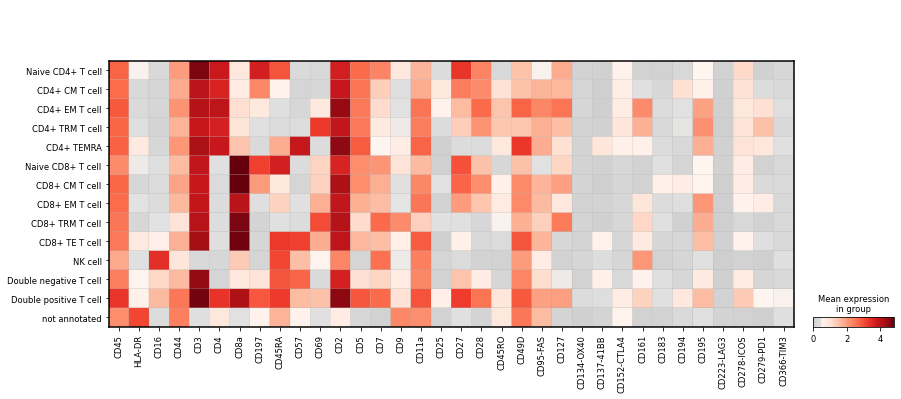

In [51]:
sc.pl.matrixplot(
    adata_cd45,
    groupby="cell_type_lvl5",
    gene_symbols="AB",
    var_names=[
        "CD45",
        "HLA-DR",
        "CD16",
        "CD44",
        "CD3",
        "CD4",
        "CD8a",
        "CD197",
        "CD45RA",
        "CD57",
        "CD69",
        "CD2",
        "CD5",
        "CD7",
        "CD9",
        "CD11a",
        "CD25",
        "CD27",
        "CD28",
        "CD45RO",
        "CD49D",
        "CD95-FAS",
        "CD127",
        "CD134-OX40",
        "CD137-41BB",
        "CD152-CTLA4",
        "CD161",
        "CD183",
        "CD194",
        "CD195",
        "CD223-LAG3",
        "CD278-ICOS",
        "CD279-PD1",
        "CD366-TIM3",
    ],
    dendrogram=False,
    vmin=0,  # standard_scale='var',
    save=f"{today}_Tcell_subtypes.pdf",
    cmap=mymap,
)

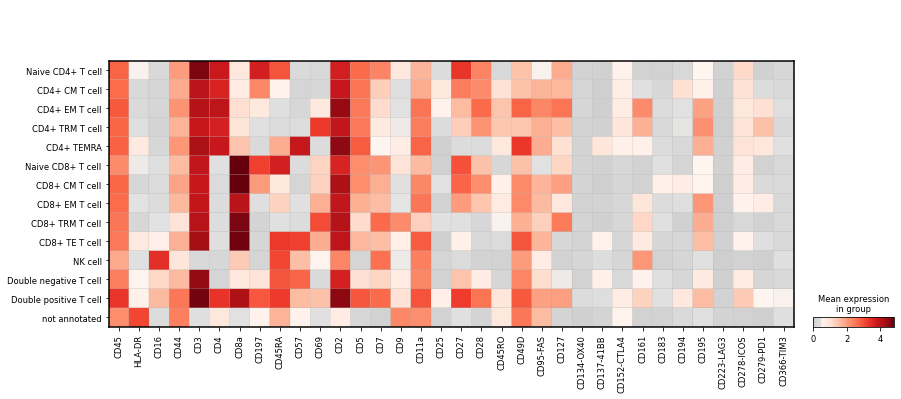

In [52]:
sc.pl.matrixplot(
    adata_cd45,
    groupby="cell_type_lvl5",
    gene_symbols="AB",
    var_names=[
        "CD45",
        "HLA-DR",
        "CD16",
        "CD44",
        "CD3",
        "CD4",
        "CD8a",
        "CD197",
        "CD45RA",
        "CD57",
        "CD69",
        "CD2",
        "CD5",
        "CD7",
        "CD9",
        "CD11a",
        "CD25",
        "CD27",
        "CD28",
        "CD45RO",
        "CD49D",
        "CD95-FAS",
        "CD127",
        "CD134-OX40",
        "CD137-41BB",
        "CD152-CTLA4",
        "CD161",
        "CD183",
        "CD194",
        "CD195",
        "CD223-LAG3",
        "CD278-ICOS",
        "CD279-PD1",
        "CD366-TIM3",
    ],
    dendrogram=False,
    vmin=0,  # standard_scale='var',
    save=f"{today}_Tcell_subtypes.png",
    cmap=mymap,
)

Visualise the cell type annotation on a UMAP plot. Save the plot as PDF and PNG file.

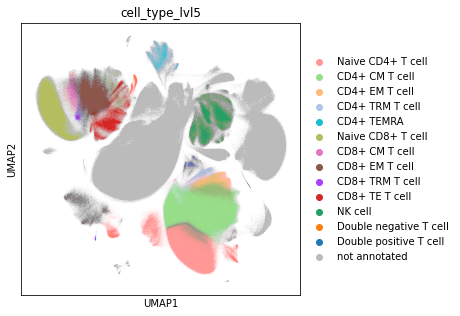

In [26]:
rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(
    adata_cd45, color="cell_type_lvl5", save="_" + today + "_cytof_cd45_lvl5.pdf"
)

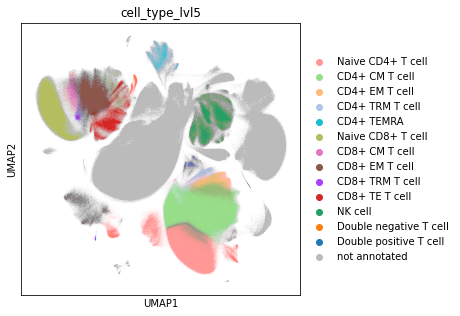

In [27]:
rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(
    adata_cd45, color="cell_type_lvl5", save="_" + today + "_cytof_cd45_lvl5.png"
)

Visualise the cells colored by donor on a UMAP and save as PDF and PNG file.

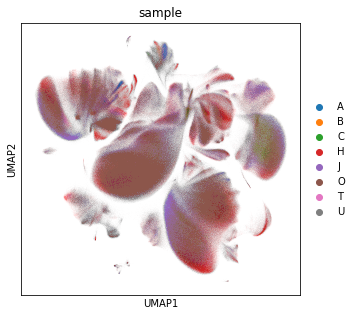

In [22]:
rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(adata_cd45, color="sample", save="_" + today + "_cytof_donor.pdf")

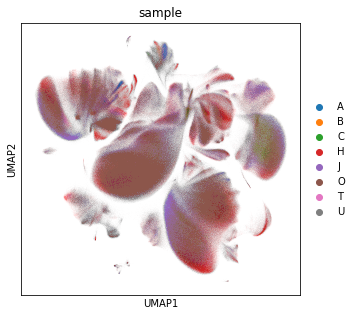

In [21]:
rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(adata_cd45, color="sample", save="_" + today + "_cytof_donor.png")

### Boxplot of cell fractions

To check our annotation, we compute the proportions of all immune cell types.

In [54]:
obs_tmp = adata_cd45.obs

In [55]:
df = pd.crosstab(obs_tmp["sample"], obs_tmp["cell_type_lvl2"], normalize=0) * 100

In [56]:
df

cell_type_lvl2   NK cell     T cell  not annotated
sample                                            
A               4.834401  62.429026      32.736573
B               9.215583  47.293266      43.491151
C               3.194541  40.332118      56.473341
H               8.470708  57.162303      34.366989
J               2.809668  51.047882      46.142450
O               6.911501  44.875164      48.213335
T               8.310561  43.141323      48.548116
U               3.746645  53.342113      42.911242

In [57]:
df.columns

CategoricalIndex(['NK cell', 'T cell', 'not annotated'], categories=['NK cell', 'T cell', 'not annotated'], ordered=False, dtype='category', name='cell_type_lvl2')

Show the proportions of NK cells, T cells and the not annotated cell types from the lowest level of granularity. Save the plot as PDF and PNG file.

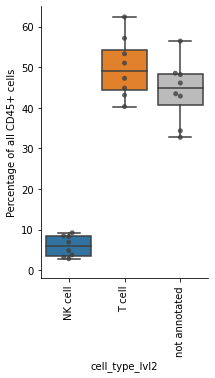

In [68]:
rcParams["figure.figsize"] = (3, 5)
ax = sb.boxplot(
    data=df[["NK cell", "T cell", "not annotated"]],
    orient="v",
    palette=["#1f77b4", "#ff7f0e", "#bbbbbb"],
)
ax = sb.swarmplot(
    data=df[["NK cell", "T cell", "not annotated"]],
    orient="v",
    color=".25",
    size=5,
    alpha=0.8,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylim([-2, 65])
ax.set_ylabel("Percentage of all CD45+ cells")
pl.savefig(f"./../figures/{today}_boxplot_Oetjen_cytof_CD45.pdf", bbox_inches="tight")
pl.show()

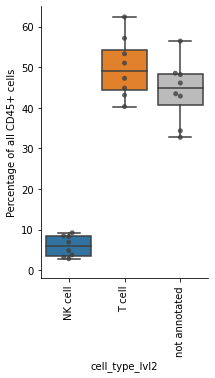

In [67]:
rcParams["figure.figsize"] = (3, 5)
ax = sb.boxplot(
    data=df[["NK cell", "T cell", "not annotated"]],
    orient="v",
    palette=["#1f77b4", "#ff7f0e", "#bbbbbb"],
)
ax = sb.swarmplot(
    data=df[["NK cell", "T cell", "not annotated"]],
    orient="v",
    color=".25",
    size=5,
    alpha=0.8,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylim([-2, 65])
ax.set_ylabel("Percentage of all CD45+ cells")
pl.savefig(f"./../figures/{today}_boxplot_Oetjen_cytof_CD45.png", bbox_inches="tight")
pl.show()

### Boxplot of T cell fractions

Next, the compute the proportions of T cell subtypes. Here we exclude the NK cells and not annotated cells. 

In [30]:
obs_tmp = adata_cd45.obs.loc[
    adata_cd45.obs["cell_type_lvl3"].isin(
        [  #'NK cell',
            "CD4+ T cell",
            "CD8+ T cell",
            "Double negative T cell",
            "Double positive T cell",
        ]
    )
]

In [37]:
df = pd.crosstab(obs_tmp["sample"], obs_tmp["cell_type_lvl5"], normalize=0) * 100

In [38]:
df

cell_type_lvl5  Naive CD4+ T cell  CD4+ CM T cell  CD4+ EM T cell  \
sample                                                              
A                       15.218739       18.446668        9.277919   
B                       25.461977       31.797843        1.793686   
C                       17.528144       36.018856        3.178619   
H                       24.642163       22.860104        2.627395   
J                       30.615129       29.517360        1.112910   
O                       10.641064       24.461048        4.141803   
T                       10.567680       28.205243        3.732956   
U                       17.355147       46.807631        2.898825   

cell_type_lvl5  CD4+ TRM T cell  CD4+ TEMRA  Naive CD8+ T cell  \
sample                                                           
A                      1.562233   12.297399           5.413229   
B                      0.501674    0.071262          14.594000   
C                      1.026850   10.130046           5.510870   
H                      0.357778    2.913099          13.428097   
J                      0.390318    0.052575          25.830372   
O                      0.583726    4.449321          14.672224   
T                      0.509420    0.084903          23.841655   
U                      1.308842    0.199634          15.293840   

cell_type_lvl5  CD8+ CM T cell  CD8+ EM T cell  CD8+ TRM T cell  \
sample                                                            
A                     1.259448       19.655145         0.260562   
B                     3.018309       14.359816         0.045442   
C                     1.849318       18.156945         0.724399   
H                     2.484190       10.187133         0.819662   
J                     1.065803        7.704990         0.206515   
O                     1.583755       19.141179         0.690654   
T                     2.576148       23.647271         1.011579   
U                     1.898293       10.336070         0.485500   

cell_type_lvl5  CD8+ TE T cell  Double negative T cell  Double positive T cell  
sample                                                                          
A                    14.125899                0.203885                2.278874  
B                     5.029396                0.719333                2.607261  
C                     3.828847                1.161181                0.885926  
H                    14.139649                3.561057                1.979673  
J                     1.324473                0.901769                1.277786  
O                    13.268893                4.477711                1.888620  
T                     1.069112                3.319611                1.434421  
U                     1.025338                1.152915                1.237966

In [39]:
df.columns

CategoricalIndex(['Naive CD4+ T cell', 'CD4+ CM T cell', 'CD4+ EM T cell',
                  'CD4+ TRM T cell', 'CD4+ TEMRA', 'Naive CD8+ T cell',
                  'CD8+ CM T cell', 'CD8+ EM T cell', 'CD8+ TRM T cell',
                  'CD8+ TE T cell', 'Double negative T cell',
                  'Double positive T cell'],
                 categories=['Naive CD4+ T cell', 'CD4+ CM T cell', 'CD4+ EM T cell', 'CD4+ TRM T cell', 'CD4+ TEMRA', 'Naive CD8+ T cell', 'CD8+ CM T cell', 'CD8+ EM T cell', ...], ordered=False, dtype='category', name='cell_type_lvl5')

Plot the proportions of T cell subtypes as boxplots. Every dot is the proportion from a single donor. Save the plots as PDF and PNG file. 

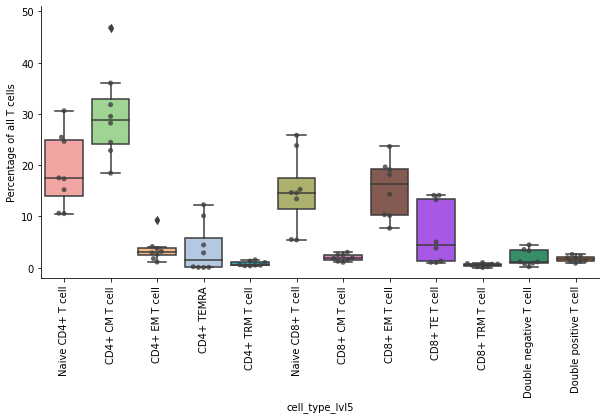

In [49]:
rcParams["figure.figsize"] = (10, 5)
ax = sb.boxplot(
    data=df[
        [
            "Naive CD4+ T cell",
            "CD4+ CM T cell",
            "CD4+ EM T cell",
            "CD4+ TEMRA",
            "CD4+ TRM T cell",
            "Naive CD8+ T cell",
            "CD8+ CM T cell",
            "CD8+ EM T cell",
            "CD8+ TE T cell",
            "CD8+ TRM T cell",
            "Double negative T cell",
            "Double positive T cell",
        ]
    ],
    orient="v",
    palette=adata_cd45.uns["cell_type_lvl5_colors"],
)
ax = sb.swarmplot(
    data=df[
        [
            "Naive CD4+ T cell",
            "CD4+ CM T cell",
            "CD4+ EM T cell",
            "CD4+ TEMRA",
            "CD4+ TRM T cell",
            "Naive CD8+ T cell",
            "CD8+ CM T cell",
            "CD8+ EM T cell",
            "CD8+ TE T cell",
            "CD8+ TRM T cell",
            "Double negative T cell",
            "Double positive T cell",
        ]
    ],
    orient="v",
    color=".25",
    size=5,
    alpha=0.8,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylim([-2, 51])
ax.set_ylabel("Percentage of all T cells")
pl.savefig(f"./../figures/{today}_boxplot_Oetjen_cytof.pdf", bbox_inches="tight")
pl.show()

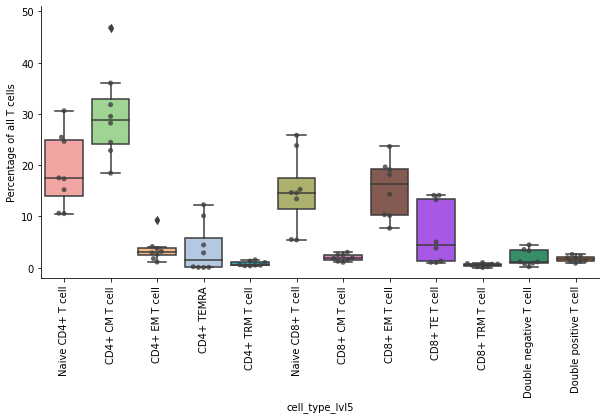

In [53]:
rcParams["figure.figsize"] = (10, 5)
ax = sb.boxplot(
    data=df[
        [
            "Naive CD4+ T cell",
            "CD4+ CM T cell",
            "CD4+ EM T cell",
            "CD4+ TEMRA",
            "CD4+ TRM T cell",
            "Naive CD8+ T cell",
            "CD8+ CM T cell",
            "CD8+ EM T cell",
            "CD8+ TE T cell",
            "CD8+ TRM T cell",
            "Double negative T cell",
            "Double positive T cell",
        ]
    ],
    orient="v",
    palette=adata_cd45.uns["cell_type_lvl5_colors"],
)
ax = sb.swarmplot(
    data=df[
        [
            "Naive CD4+ T cell",
            "CD4+ CM T cell",
            "CD4+ EM T cell",
            "CD4+ TEMRA",
            "CD4+ TRM T cell",
            "Naive CD8+ T cell",
            "CD8+ CM T cell",
            "CD8+ EM T cell",
            "CD8+ TE T cell",
            "CD8+ TRM T cell",
            "Double negative T cell",
            "Double positive T cell",
        ]
    ],
    orient="v",
    color=".25",
    size=5,
    alpha=0.8,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylim([-2, 51])
ax.set_ylabel("Percentage of all T cells")
pl.savefig(f"./../figures/{today}_boxplot_Oetjen_cytof.png", bbox_inches="tight")
pl.show()

End of the annotation notebook.